# Carga de LoRA para inferencia

*Este notebook es una adaptación de:* https://huggingface.co/docs/diffusers/tutorials/using_peft_for_inference

En el contexto de modelos de difusión, un adaptador es un método que consiste en añadir más parámetros después las capas de atención y las totalmente conectadas de un modelo existente y ya entrenado. Es una alternativa de bajo coste computacional a realizar fine-tuning del modelo completo.

Una de las técnicas más conocidas de este tipo es LoRA (*Low-Rank Adaptation*). Se desarrolló inicialmente para modelos de lenguaje pero se ha popularizado su uso con modelo de difusión. LoRA acelera el fine-tuning de modelos y consume menos memoria. 

LoRA está basado en representar la actualización de los parámetros del modelo a través de dos matrices más pequeñas (llamadas matrices de actualización). Estas matrices se pueden entrenar para adaptarse al nuevo dataset (de finetuning) pero manteniendo el número total de parámetros bajo. La matriz original de parámetros no cambia al no recibir ninguna actualización. Los resultados finales se obtienen combinando los parámetros (congelados) y los nuevos parámetros de adaptación ahora entrenados. Esto tiene el inconveniente de requerir más cálculos para la inferencia de la versión adaptada del modelo. Para evitarlo, podemos fusionar los parámetros de adaptación con los parámetros originales del modelo.

Esta aproximación produce varios beneficios:

- El fine-tuning de modelos es mucho más eficiente al reducir el número de parámetros entrenables.
- Los pesos del modelo original se pueden mantener congelados, lo cual nos permite tener varias adaptaciones LoRA intercambiables aplicables a un mismo modelo base. 
- LoRA se puede combinar con otros métodos de adaptación.
- La calidad de la generación de un modelo adaptado mediante esta técnica es comparable a la de un modelo sometido a un proceso de fine-tuning convencional.

LoRA se puede utilizar dentro de la librería Diffusers a través de su integración con otra librería de HuggingFace: [PEFT (Parameter-Efficient Fine-tuning)](https://huggingface.co/docs/peft/index)

In [6]:
%pip install -q transformers accelerate peft diffusers sentencepiece

Note: you may need to restart the kernel to use updated packages.


Vamos a hacer una demonstración a partir de un checkpoint de Stable Diffusion XL (SDXL).

*NOTA: Esta demo necesitar usar un nodo con una GPU Nvidia A100*

In [1]:
from diffusers import DiffusionPipeline
import torch
import os
store_path = os.getenv('STORE')
pipe_id = "stabilityai/stable-diffusion-xl-base-1.0"
#pipe_id = "latent-consistency/lcm-sdxl"
#pipe_id = "black-forest-labs/FLUX.1-schnell"
pipe = DiffusionPipeline.from_pretrained(pipe_id, torch_dtype=torch.float16, cache_dir=os.path.join(store_path, "HFCache")).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

A continuación cargamos un adaptador de LoRA (CiroN2022/toy-face) usando el método *load_lora_weights()*. Con la integración con la librería *PEFT (Parameter-Efficient Fine-Tuning)* podemos usar diferentes adaptadores simplemente especificándolo en el parámetro *adapter_name*, lo cual nos permite alternar entre diferentes checkpoints de LoRA.

In [2]:
pipe.load_lora_weights("CiroN2022/toy-face", weight_name="toy_face_sdxl.safetensors", adapter_name="toy")

toy_face_sdxl.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

Asegúrate de usar el token *toy_face* en el prompt para poder realizar inferencia.

  0%|          | 0/30 [00:00<?, ?it/s]

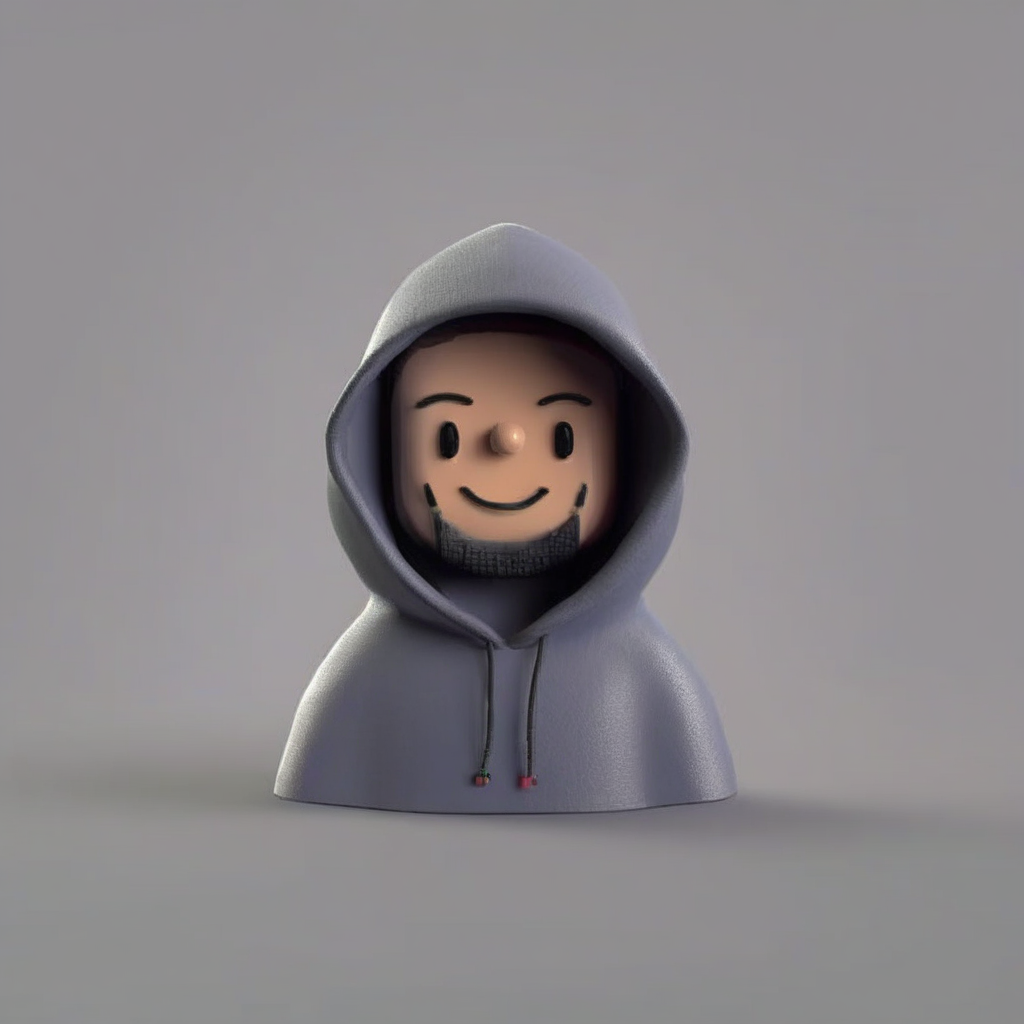

In [3]:
prompt = "toy_face of a hacker with a hoodie"

lora_scale = 0.9
image = pipe(
    prompt, num_inference_steps=30, cross_attention_kwargs={"scale": lora_scale}, generator=torch.manual_seed(0)
).images[0]
image

Usando el parámetro *adapter_name* resulta realmente sencillo cambiar el adaptador utilizado para inferencia. Carguemos ahora [nerijs/pixel-art-xl](https://huggingface.co/nerijs/pixel-art-xl) que ha sido fine-tuned para generar imágenes de tipo pixel art. Para desencadenarlo, necesitamos incluir el token *pixel art* en el prompt.

Cuando hemos cargados dos adaptadores diferentes mediante la función *load_lora_weights*, el pipeline considera activo por defecto el primero que cargamos. La función *set_adapters* nos permite usar otro distinto.

In [4]:
pipe.load_lora_weights("nerijs/pixel-art-xl", weight_name="pixel-art-xl.safetensors", adapter_name="pixel")
pipe.set_adapters("pixel")

pixel-art-xl.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

  0%|          | 0/30 [00:00<?, ?it/s]

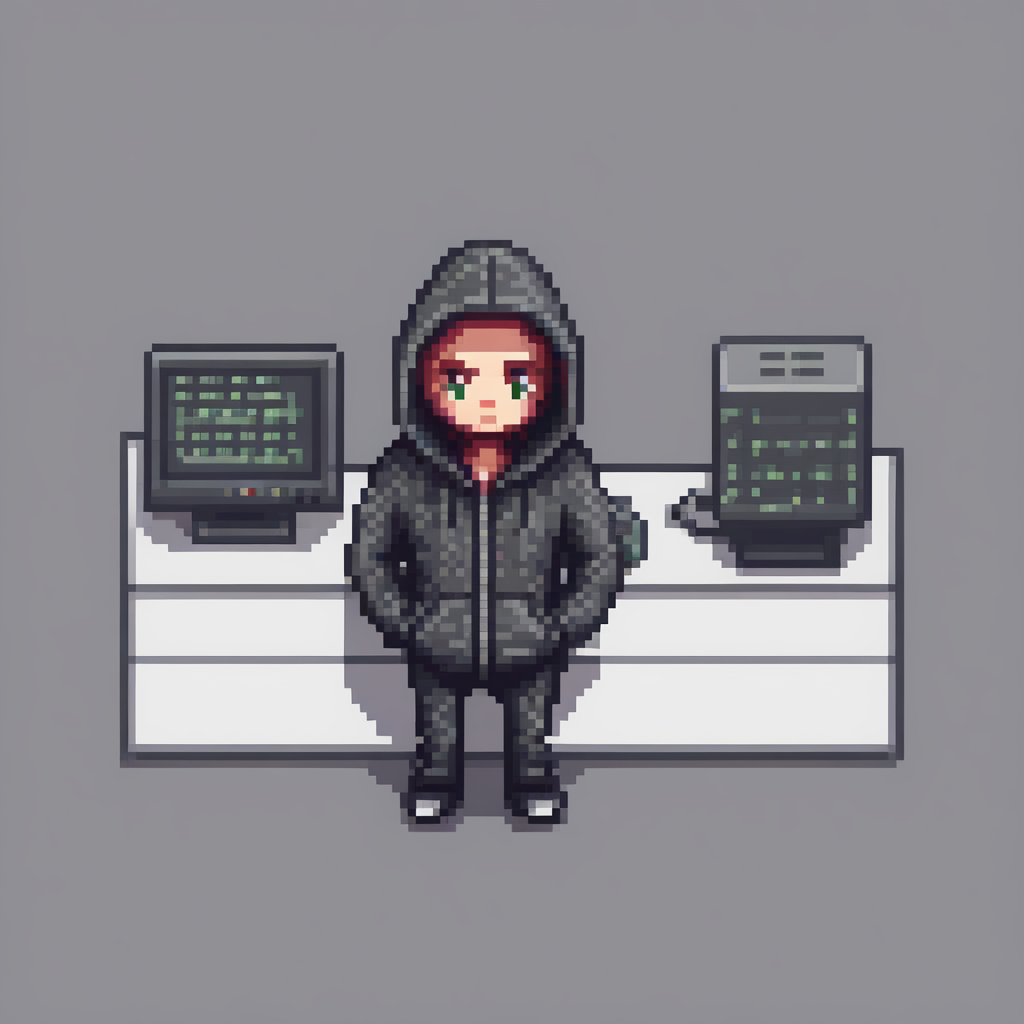

In [5]:
prompt = "a hacker with a hoodie, pixel art"
image = pipe(
    prompt, num_inference_steps=30, cross_attention_kwargs={"scale": lora_scale}, generator=torch.manual_seed(0)
).images[0]
image

## Combinación de adaptadores

También es posible mezclar varios checkpoints de adaptadores de inferencia para combinarlos. Para ello utilizaremos el método *set_adapters* y le pasaremos una lista de adaptadores de mezcla y una lista de pesos indicando la importancia que queremos darle a cada uno de ellos en el generación.

> Los checkpoint de LoRA de la comunidad de Diffusion se generan principalmente usando [DreamBooth](https://huggingface.co/docs/diffusers/main/en/) 
> training/dreambooth). El entrenamiento en DreamBooth normalmente asociar palabras clave determinadas en el prompt de entrada para desencadenar el uso
>  de un determinado adaptador. Cuando combinas varios, las palabras clave desencadenantes de los adaptadores combinados tienen que estar presentes en
> el prompt.

  0%|          | 0/30 [00:00<?, ?it/s]

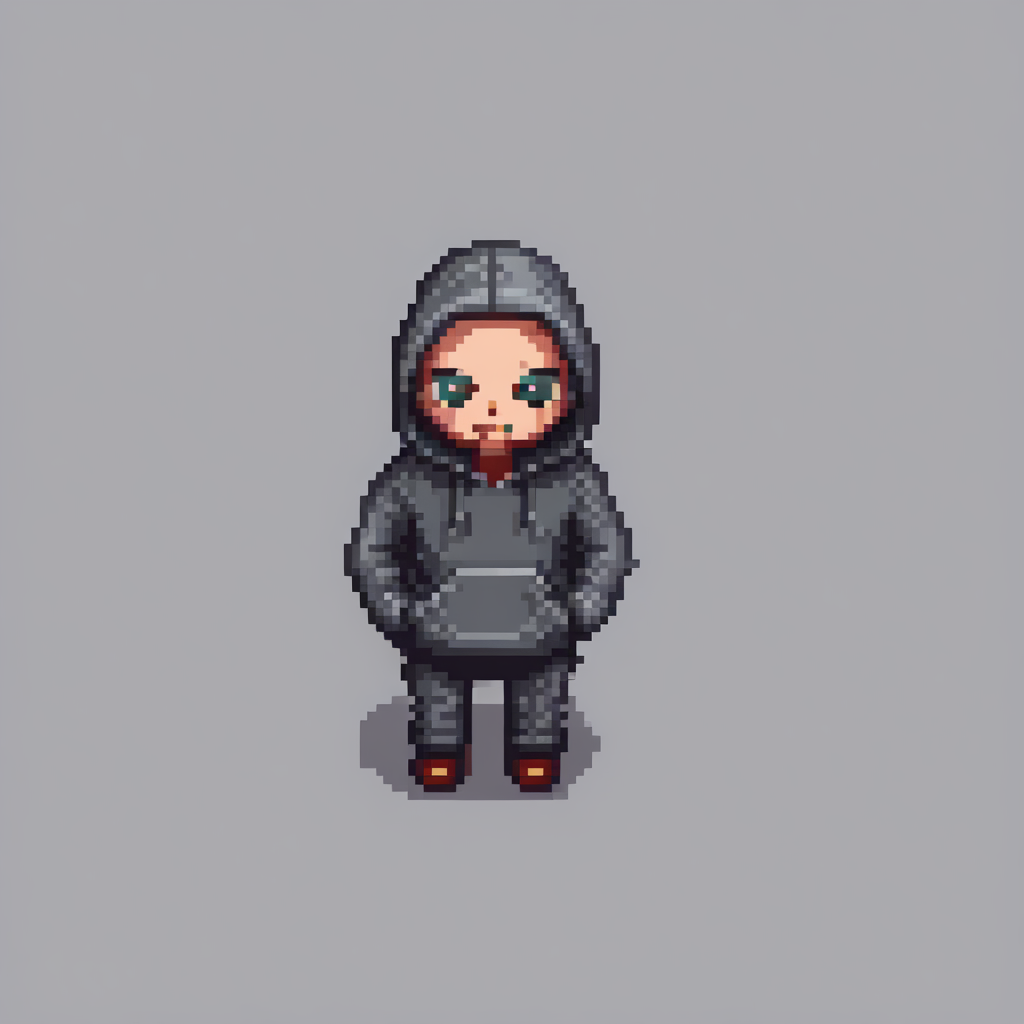

In [6]:
prompt = "toy_face of a hacker with a hoodie, pixel art"
image = pipe(
    prompt, num_inference_steps=30, cross_attention_kwargs={"scale": 1.0}, generator=torch.manual_seed(0)
).images[0]
image

Para volver a usar el modelo basey deshabilitar el uso de adaptadores, podemos utilizar la función *disable_lora*

  0%|          | 0/30 [00:00<?, ?it/s]

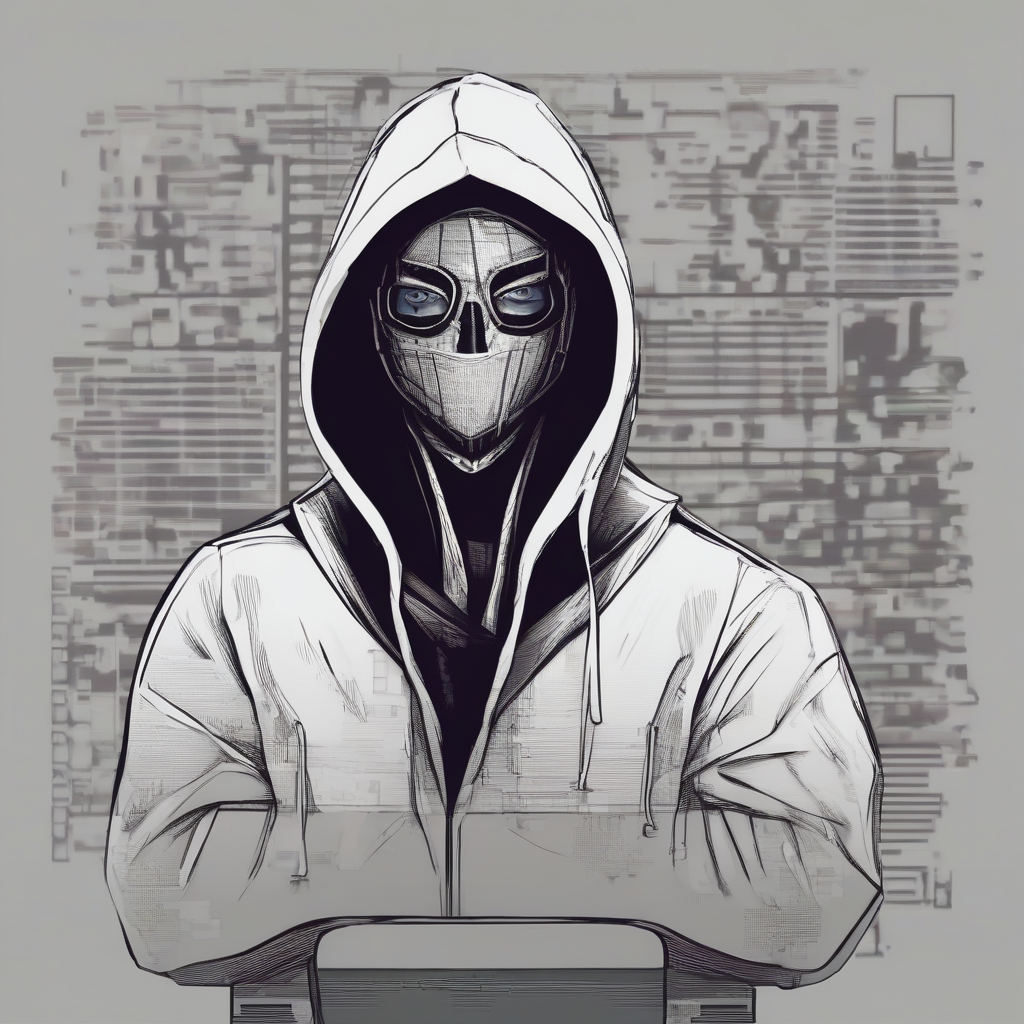

In [7]:
pipe.disable_lora()

prompt = "toy_face of a hacker with a hoodie"
image = pipe(prompt, num_inference_steps=30, generator=torch.manual_seed(0)).images[0]
image

## Personalizando la fortaleza de los adaptadores

Para una personalización mayor, podemos controlar lo mucho que un adaptador afecta a cada parte del pipeline. Para ello, vamos a pasar un diccionario *scales* a la llamada a la función *set_adapters*. Por ejemplo, veamos un ejemplo donde activamos el adaptador para las partes *down* del modelo, pero lo desactivamos para las partes *mid* y *up*.

  0%|          | 0/30 [00:00<?, ?it/s]

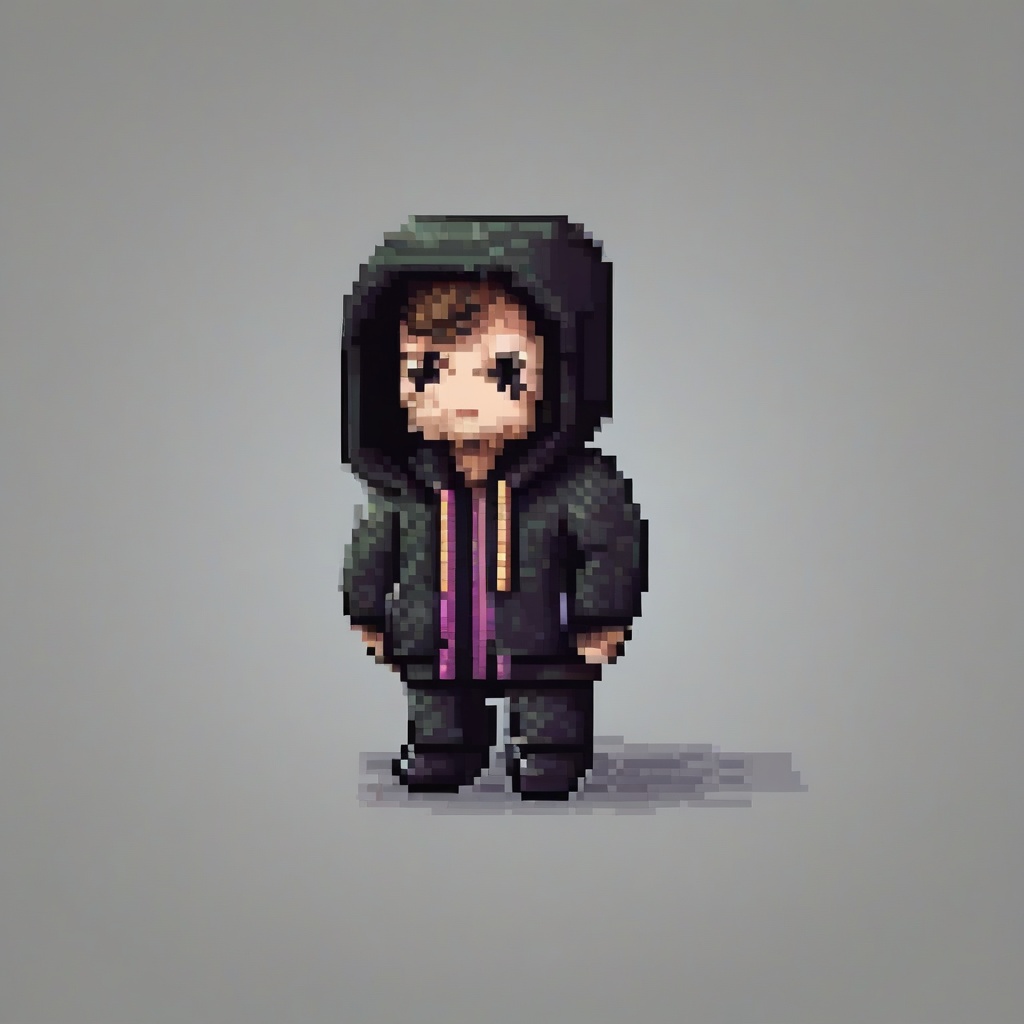

In [8]:
pipe.enable_lora()  # enable lora again, after we disabled it above
prompt = "toy_face of a hacker with a hoodie, pixel art"
adapter_weight_scales = { "unet": { "down": 1, "mid": 0, "up": 0} }
pipe.set_adapters("pixel", adapter_weight_scales)
image = pipe(prompt, num_inference_steps=30, generator=torch.manual_seed(0)).images[0]
image

Veamos ahora, cómo desactivar la parte *down* y activar las otras dos (*up* y *mid*) afecta a la generación.

  0%|          | 0/30 [00:00<?, ?it/s]

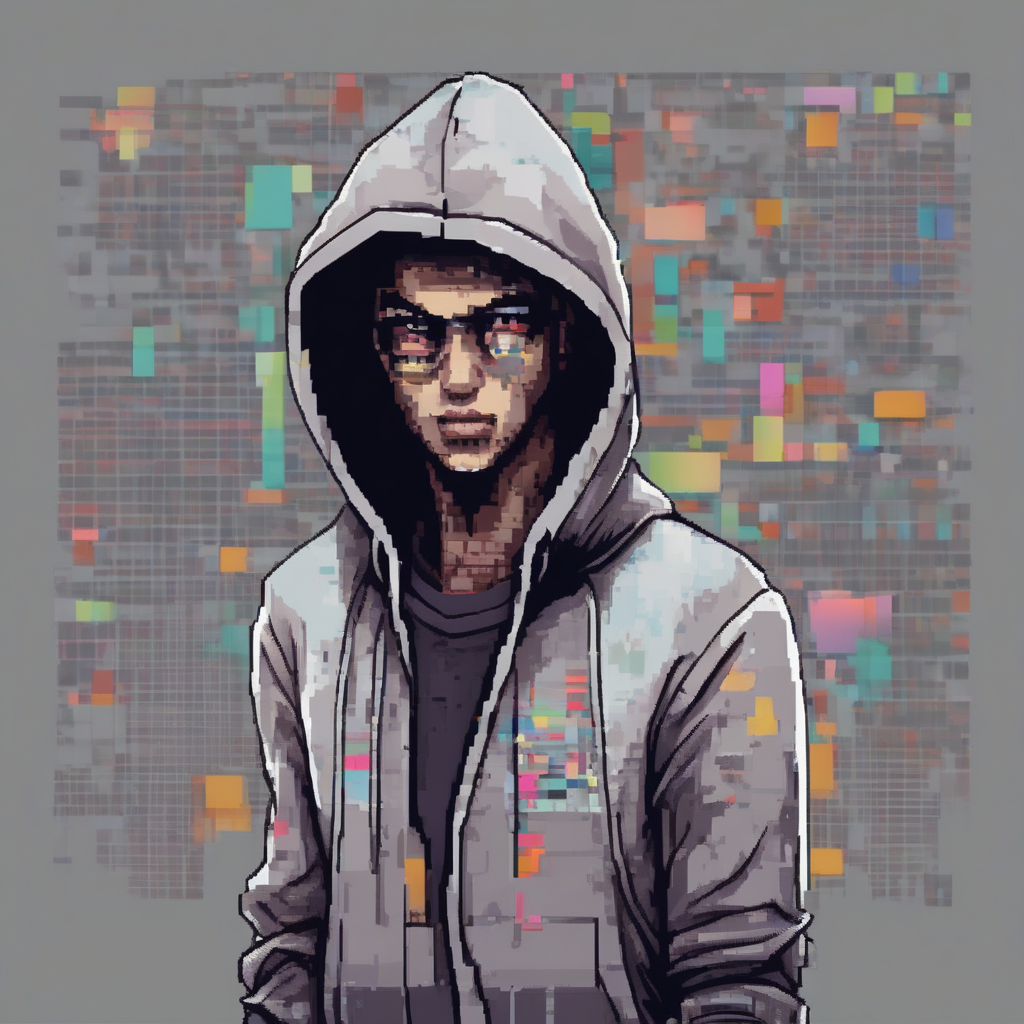

In [9]:
adapter_weight_scales = { "unet": { "down": 0, "mid": 1, "up": 0} }
pipe.set_adapters("pixel", adapter_weight_scales)
image = pipe(prompt, num_inference_steps=30, generator=torch.manual_seed(0)).images[0]
image

Probemos finalmente otra combinación.

  0%|          | 0/30 [00:00<?, ?it/s]

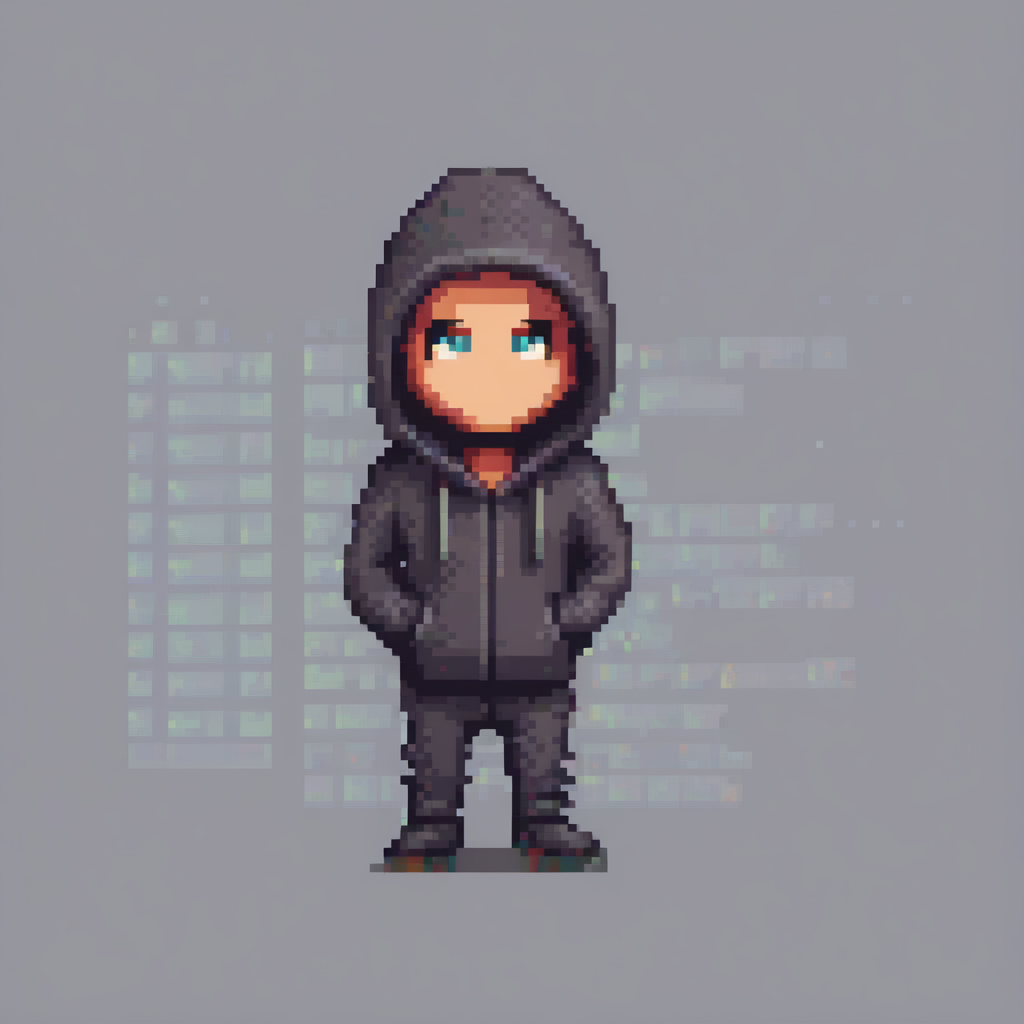

In [10]:
adapter_weight_scales = { "unet": { "down": 0, "mid": 0, "up": 1} }
pipe.set_adapters("pixel", adapter_weight_scales)
image = pipe(prompt, num_inference_steps=30, generator=torch.manual_seed(0)).images[0]
image

Podemos incluso adaptar las fortalezas a un grano mucho más fino, y esta adaptación además, se puede utilizar de forma simultánea para múltiples adaptadores.

  0%|          | 0/30 [00:00<?, ?it/s]

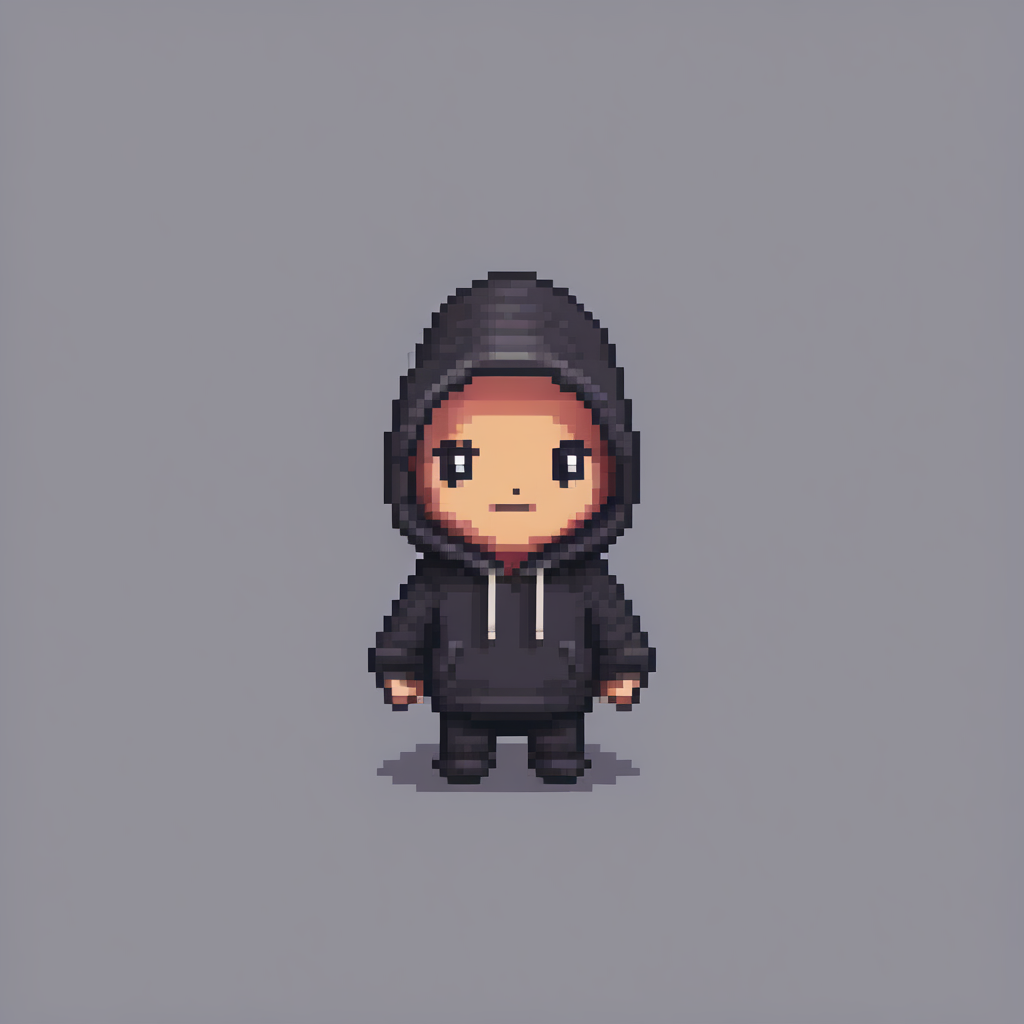

In [11]:
adapter_weight_scales_toy = 0.5
adapter_weight_scales_pixel = {
    "unet": {
        "down": 0.9,  # all transformers in the down-part will use scale 0.9
        # "mid"  # because, in this example, "mid" is not given, all transformers in the mid part will use the default scale 1.0
        "up": {
            "block_0": 0.6,  # all 3 transformers in the 0th block in the up-part will use scale 0.6
            "block_1": [0.4, 0.8, 1.0],  # the 3 transformers in the 1st block in the up-part will use scales 0.4, 0.8 and 1.0 respectively
        }
    }
}
pipe.set_adapters(["toy", "pixel"], [adapter_weight_scales_toy, adapter_weight_scales_pixel])
image = pipe(prompt, num_inference_steps=30, generator=torch.manual_seed(0)).images[0]
image

## Manejo de adaptadores

Como vemos, diferentes métodos nos permiten activar y desactivar adaptadores, podemos saber en todo momento cuáles están activados usando la función *get_active_adapters()*. 

También podemos usar el método *get_list_adapters()* para comprobar cuáles están activos para cada componente del modelo.

La función *delete_adapters*, permite borrar un adaptador y sus capas de adaptación de un modelo.

In [12]:
active_adapters = pipe.get_active_adapters()
active_adapters
["toy", "pixel"]

['toy', 'pixel']

In [13]:
list_adapters_component_wise = pipe.get_list_adapters()
list_adapters_component_wise
{"text_encoder": ["toy", "pixel"], "unet": ["toy", "pixel"], "text_encoder_2": ["toy", "pixel"]}

{'text_encoder': ['toy', 'pixel'],
 'unet': ['toy', 'pixel'],
 'text_encoder_2': ['toy', 'pixel']}

In [14]:
pipe.delete_adapters("toy")
pipe.get_active_adapters()
["pixel"]

['pixel']